**Kate Groschner** <br>
**AY250 Homework 6**

## Question 1

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage 
from skimage import io
from skimage.color import rgb2gray
import os
import skimage.feature
import skimage.filters
import skimage.color
from skimage.util import invert
from skimage.morphology import skeletonize
from scipy.signal import correlate2d
import pandas as pd
import cv2
from pathlib import Path
from joblib import Parallel, delayed
from tqdm import tqdm

def import_exImg():
    sample_images = {}
    if os.getcwd().split('/')[-1] != '50_categories':
        exit()
    files = os.listdir()
    for idx, direct in enumerate(files):
        if idx == 0:
            pass
        else:
            os.chdir(direct)
            file = os.listdir()[0]
            img = io.imread(file)
            sample_images[direct] = img
            os.chdir('..')
    print('Done!')
    return(sample_images)

def avg_red(img):
    """returns average value of red channel"""
    if len(img.shape) != 3:
        img = skimage.color.gray2rgb(img)
    avg = [img[:,:,0].mean()]
    return np.array(avg)

def avg_blue(img):
    """returns average value of blue channel"""
    if len(img.shape) != 3:
        img = skimage.color.gray2rgb(img)
    avg = [img[:,:,1].mean()]
    return np.array(avg)

def avg_green(img):
    """returns average value of green channel"""
    if len(img.shape) != 3:
        img = skimage.color.gray2rgb(img)
    avg = [img[:,:,2].mean()]
    return np.array(avg)

# edges from sobel
def sobel_edges(gray_image):
    """Returns histogram of edges and average of edges"""
    edges = skimage.filters.sobel(gray_image)
    edge_hist = np.histogram(edges,bins=250, density = True)[0]
    return edge_hist

# number of blobs from difference of gaussian
def blobs_dog(gray_image):
    """returns two features: average blob size and total number of blobs detected by difference of gaussians"""
    blob = skimage.feature.blob_dog(gray_image, max_sigma=50, threshold=.1)
    blobs = blob[:,2]
    avg_blob = blobs.mean()
    num_blobs = len(blobs)
    blob_info = np.array([avg_blob, num_blobs])
    return blob_info

def blobs_log(gray_image):
    """returns two features: average blob size and total number of blobs detected by laplace of gaussians"""
    blob = skimage.feature.blob_log(gray_image, max_sigma=5, num_sigma=10, threshold=.1)
    blobs = blob[:,2]
    avg_blob = blobs.mean()
    num_blobs = len(blobs)
    blob_info = np.array([avg_blob, num_blobs])
    return blob_info

def fft_hist(gray_image):
    """returns 250 bin histogram of frequencies from fft of image"""
    fft = np.log2(abs(np.fft.rfft2(gray_image)))
    fhist = np.histogram(fft,bins=250,density = True)[0]
    return fhist

def lbp_hist(gray_image):
    """returns 250 bin histogram of local binary patterns from image"""
    lbp = skimage.feature.local_binary_pattern(gray_image,30,30)
    lhist = np.histogram(lbp,bins=250,density = True)[0]
    return lhist

def center_cut(image):
    """returns a 1d array of length 1200 which is 20x20 center of image of all three channels flattened"""
    if len(image.shape) != 3:
        image = skimage.color.gray2rgb(image)
    middle = (image.shape[0]//2,image.shape[1]//2)
    cut = image[(middle[0]-10):(middle[0]+10),(middle[1]-10):(middle[1]+10),:].flatten()
    return cut

def avg_HSV(image):
    """returns the average for hue, saturation, and value from image"""
    if len(image.shape) == 3:
        img_out = skimage.color.rgb2hsv(image)
    else:
        img_out = skimage.color.rgb2hsv(skimage.color.grey2rgb(image))
    results = [img_out[:,:,0].mean(),img_out[:,:,1].mean(),img_out[:,:,2].mean()]
    return np.array(results)

def sift10(image):
    """returns 1d array of length 1280 which represents the first 10 SIFT features of the image"""
    if len(image.shape) != 3:
        image = skimage.color.gray2rgb(image)
    sift = cv2.xfeatures2d.SIFT_create()
    _, des = sift.detectAndCompute(image,None)
    if des.shape[0] <= 10:
        dif = 10 - des.shape[0]
        filler = np.zeros((dif,128))
        sift = np.concatenate((des,filler),axis=0).flatten()
    else:
        sift = des[:10,:].flatten()
    return sift

def color_hist(image):
    """returns 1d array of length 300 representing the color histogram for red,blue, and green channels"""
    hist = []
    if len(image.shape) == 3:
        for i in range(0,3):
            hist.append(np.histogram(image[:,:,i],bins=100, density = True)[0])
    else:
        for i in range(0,3):
            hist.append(np.histogram(image,bins=100, density = True)[0])
    hist = np.concatenate(hist)
    return hist

def get_features(file):
    image = io.imread(file)
    label = file.parent.name
    gray_image = rgb2gray(image)
#     print(file)
    features = [] 
    features.append(color_hist(image))
    features.append(sift10(image))
    features.append(avg_HSV(image))
    features.append(center_cut(image))
    features.append(lbp_hist(gray_image))
    features.append(fft_hist(gray_image))
    features.append(blobs_log(gray_image))
    features.append(blobs_dog(gray_image))
    features.append(sobel_edges(gray_image))
    features.append(avg_green(image))
    features.append(avg_blue(image))
    features.append(avg_red(image))
    features = np.concatenate(features)
    return (features,label)


In [45]:
def feature_frame(directory):
    files = list(Path(directory).glob('*/*.jpg'))
#     np.random.seed(42)
#     file_list = np.random.choice(files,100)
    features = Parallel(n_jobs=-1)(delayed(get_features)(file) for file in tqdm(files))
    print('Done!')
    feat_list, labels_list = zip(*features)
    df = pd.DataFrame.from_records(feat_list)
    df['Label'] = labels_list
    return df

In [46]:
directory = '/Users/cgroschner/Documents/pythonLearn/groschner-python-ay250-homework/hw_6/50_categories'
df_full = feature_frame(directory)
csv_name = directory + '/all_features.csv'
df_full.to_csv(csv_name)

 20%|██        | 853/4244 [03:16<12:59,  4.35it/s]/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 67%|██████▋   | 2838/4244 [18:00<08:55,  2.63it/s]/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice.
/Users/cgroschner/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 4244/4244 [31:46<00:00,  2.23it/s]


Done!


In [4]:
directory = '/Users/cgroschner/Documents/pythonLearn/groschner-python-ay250-homework/hw_6/50_categories'

np.random.seed(42)
files = list(Path(directory).glob('*/*.jpg'))
file_list = np.random.choice(files,100)
file_list[4]

PosixPath('/Users/cgroschner/Documents/pythonLearn/groschner-python-ay250-homework/hw_6/50_categories/saturn/saturn_0002.jpg')

In [6]:
df = pd.read_csv(directory+'/features.csv')

In [7]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,3531,3532,3533,3534,3535,3536,3537,3538,3539,Label
0,0,0.025110,0.018770,0.020958,0.034464,0.018808,0.026511,0.014981,0.020233,0.012167,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.012332,32.523756,33.069420,30.501913,comet
1,1,0.001691,0.003303,0.002824,0.008314,0.007970,0.005322,0.003088,0.004229,0.003518,...,0.000000,0.000000,0.014096,0.007048,0.000000,0.007048,125.360291,133.424845,135.834574,speed-boat
2,2,0.001169,0.000889,0.000912,0.001536,0.001294,0.002642,0.001902,0.003196,0.002050,...,0.007928,0.007928,0.000000,0.000000,0.007928,0.007928,95.778772,156.762552,138.274975,ostrich
3,3,0.000205,0.000230,0.000211,0.000547,0.000540,0.001453,0.001174,0.002609,0.002050,...,0.019038,0.025384,0.031729,0.006346,0.000000,0.019038,91.767532,83.981644,70.983497,airplanes
4,4,0.204038,0.013150,0.007371,0.006915,0.003806,0.004942,0.004129,0.005017,0.001492,...,0.000000,0.002914,0.002914,0.002914,0.014569,0.008742,38.448656,40.500436,44.199605,saturn


In [ ]:
b = sift10(a)

In [ ]:
plt.plot(b)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 3541 entries, 0 to Label
dtypes: float64(3540), object(1)
memory usage: 2.7+ MB


In [47]:
df_full.head()

,0,1,2,3,4,5,6,7,8,9,...,3531,3532,3533,3534,3535,3536,3537,3538,3539,Label
0,0.000102,0.000637,0.001154,0.001166,0.000745,0.001069,0.000691,0.001063,0.000871,0.001051,...,0.0,0.0,0.000000,0.0,0.000000,0.005685,149.151581,176.750337,183.355727,airplanes
1,0.000005,0.000000,0.000033,0.000027,0.000022,0.000165,0.000318,0.000313,0.001344,0.001712,...,0.0,0.0,0.000000,0.0,0.005947,0.005947,164.805242,189.280101,210.739822,airplanes
2,0.000091,0.000054,0.000042,0.000169,0.000139,0.000302,0.000351,0.000968,0.001137,0.001609,...,0.0,0.0,0.006931,0.0,0.000000,0.013861,111.753798,147.788681,170.123787,airplanes
3,0.000202,0.000541,0.000422,0.000808,0.000719,0.001111,0.000742,0.001111,0.000796,0.001633,...,0.0,0.0,0.000000,0.0,0.000000,0.006210,77.917303,132.648316,152.159752,airplanes
4,0.001512,0.002454,0.002358,0.003249,0.001698,0.002256,0.001416,0.002076,0.001630,0.002725,...,0.0,0.0,0.000000,0.0,0.000000,0.005851,86.252963,150.504790,147.397886,airplanes


## Question 2

In [18]:
directory = '/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/50_categories'
csv_name = directory + '/all_features.csv'
df_full = pd.read_csv(csv_name)
df_full.fillna(value=0)


,Unnamed: 0,Unnamed: 0.1,0,1,2,3,4,5,6,7,...,3531,3532,3533,3534,3535,3536,3537,3538,3539,Label
0,0,0,0.025110,0.018770,0.020958,0.034464,0.018808,0.026511,0.014981,0.020233,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.012332,32.523756,33.069420,30.501913,comet
1,1,1,0.001691,0.003303,0.002824,0.008314,0.007970,0.005322,0.003088,0.004229,...,0.000000,0.000000,0.014096,0.007048,0.000000,0.007048,125.360291,133.424845,135.834574,speed-boat
2,2,2,0.001169,0.000889,0.000912,0.001536,0.001294,0.002642,0.001902,0.003196,...,0.007928,0.007928,0.000000,0.000000,0.007928,0.007928,95.778772,156.762552,138.274975,ostrich
3,3,3,0.000205,0.000230,0.000211,0.000547,0.000540,0.001453,0.001174,0.002609,...,0.019038,0.025384,0.031729,0.006346,0.000000,0.019038,91.767532,83.981644,70.983497,airplanes
4,4,4,0.204038,0.013150,0.007371,0.006915,0.003806,0.004942,0.004129,0.005017,...,0.000000,0.002914,0.002914,0.002914,0.014569,0.008742,38.448656,40.500436,44.199605,saturn
5,5,5,0.000227,0.000953,0.001430,0.001598,0.000890,0.002138,0.002837,0.014434,...,0.004386,0.000000,0.000000,0.000000,0.000000,0.004386,43.472905,44.517083,44.416748,owl
6,6,6,0.000601,0.000719,0.000928,0.001464,0.001340,0.002268,0.001529,0.002536,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.006472,99.711983,75.293250,80.635833,mussels
7,7,7,0.000237,0.000231,0.000189,0.000402,0.000432,0.000935,0.000835,0.001462,...,0.000000,0.011861,0.000000,0.005931,0.000000,0.005931,106.557882,144.234560,143.498657,airplanes
8,8,8,0.001075,0.000563,0.000312,0.000298,0.000192,0.000277,0.000227,0.000338,...,0.002644,0.001322,0.002644,0.001322,0.000000,0.001322,91.372919,106.246174,116.955160,goat
9,9,9,0.000021,0.000021,0.000083,0.000208,0.000583,0.000521,0.001125,0.001042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.025318,159.565365,155.611198,162.421771,camel


In [14]:
df_full.columns.values

array(['Unnamed: 0', 'Unnamed: 0.1', '0', ..., '3538', '3539', 'Label'],
      dtype=object)

In [19]:
df_full.drop(['Unnamed: 0.1','Unnamed: 0'] ,axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,3531,3532,3533,3534,3535,3536,3537,3538,3539,Label
0,0.025110,0.018770,0.020958,0.034464,0.018808,0.026511,0.014981,0.020233,0.012167,0.015781,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.012332,32.523756,33.069420,30.501913,comet
1,0.001691,0.003303,0.002824,0.008314,0.007970,0.005322,0.003088,0.004229,0.003518,0.004731,...,0.000000,0.000000,0.014096,0.007048,0.000000,0.007048,125.360291,133.424845,135.834574,speed-boat
2,0.001169,0.000889,0.000912,0.001536,0.001294,0.002642,0.001902,0.003196,0.002050,0.003274,...,0.007928,0.007928,0.000000,0.000000,0.007928,0.007928,95.778772,156.762552,138.274975,ostrich
3,0.000205,0.000230,0.000211,0.000547,0.000540,0.001453,0.001174,0.002609,0.002050,0.004298,...,0.019038,0.025384,0.031729,0.006346,0.000000,0.019038,91.767532,83.981644,70.983497,airplanes
4,0.204038,0.013150,0.007371,0.006915,0.003806,0.004942,0.004129,0.005017,0.001492,0.002338,...,0.000000,0.002914,0.002914,0.002914,0.014569,0.008742,38.448656,40.500436,44.199605,saturn
5,0.000227,0.000953,0.001430,0.001598,0.000890,0.002138,0.002837,0.014434,0.041544,0.070071,...,0.004386,0.000000,0.000000,0.000000,0.000000,0.004386,43.472905,44.517083,44.416748,owl
6,0.000601,0.000719,0.000928,0.001464,0.001340,0.002268,0.001529,0.002536,0.002020,0.003059,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.006472,99.711983,75.293250,80.635833,mussels
7,0.000237,0.000231,0.000189,0.000402,0.000432,0.000935,0.000835,0.001462,0.001296,0.002119,...,0.000000,0.011861,0.000000,0.005931,0.000000,0.005931,106.557882,144.234560,143.498657,airplanes
8,0.001075,0.000563,0.000312,0.000298,0.000192,0.000277,0.000227,0.000338,0.000299,0.000470,...,0.002644,0.001322,0.002644,0.001322,0.000000,0.001322,91.372919,106.246174,116.955160,goat
9,0.000021,0.000021,0.000083,0.000208,0.000583,0.000521,0.001125,0.001042,0.001500,0.000729,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.025318,159.565365,155.611198,162.421771,camel


In [20]:
half = df_full.shape[0]//2
X_train = df_full.iloc[0:half,:-1]
Y_train = df_full.iloc[0:half,-1]
X_test = df_full.iloc[half:,:-1]
Y_test = df_full.iloc[half:,-1]

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Columns: 3542 entries, Unnamed: 0 to 3539
dtypes: float64(3540), int64(2)
memory usage: 1.4 MB


In [21]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
pred_rf = classifier.predict(X_test) 
match = 0
for idx, ele in enumerate(pred_rf[0:10]):
    if ele == Y_test.iloc[idx]:
        match += 1
print("True Class / Predicted class")
print(match/10)

True Class / Predicted class
0.2


In [25]:
Y_test.iloc[0]

'giraffe'

In [27]:
pred_rf[0]

'gorilla'

In [23]:
match = 0
correct_lst = []
for idx, ele in enumerate(pred_rf):
    if ele == Y_test.iloc[idx]:
        match += 1
        correct_lst.append(idx)
print('match is {}'.format(match))
print('fraction correct is {}'.format(match/50))

match is 9
fraction correct is 0.18


In [32]:
Y_test.iloc[correct_lst]

58    airplanes
65    airplanes
70    airplanes
73    airplanes
78    airplanes
93    airplanes
98         mars
Name: Label, dtype: object

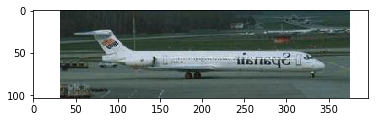

In [38]:
plt.imshow(io.imread(file_list[70]))

In [24]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# explore 3 different forest sizes and 3 choices of mtry
parameters = {'n_estimators':[10,20,30,50,70,100],  'max_features':[3,8,10,'auto'], 
             'criterion': ['gini','entropy']}
rf_tune = model_selection.GridSearchCV(RandomForestClassifier(), parameters, 
                                   n_jobs = -1, cv = 5,verbose=1)
rf_opt = rf_tune.fit(X_train, Y_train)

print("Best zero-one score: " + str(rf_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt.best_estimator_))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/kategroschner/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    9.2s finished


Best zero-one score: 0.2

Optimal Model:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


Feature ranking:
1. feature 1518 (0.001731)
2. feature 298 (0.001487)
3. feature 112 (0.001404)
4. feature 3213 (0.001363)
5. feature 413 (0.001362)
6. feature 617 (0.001359)
7. feature 946 (0.001331)
8. feature 565 (0.001325)
9. feature 3193 (0.001316)
10. feature 309 (0.001312)
11. feature 1258 (0.001309)
12. feature 954 (0.001272)
13. feature 1083 (0.001234)
14. feature 2541 (0.001220)
15. feature 2516 (0.001199)
16. feature 2749 (0.001195)
17. feature 2157 (0.001194)
18. feature 403 (0.001182)
19. feature 3428 (0.001179)
20. feature 2689 (0.001169)
21. feature 2738 (0.001155)
22. feature 649 (0.001137)
23. feature 3201 (0.001098)
24. feature 3283 (0.001096)
25. feature 1976 (0.001081)
26. feature 618 (0.001072)
27. feature 2694 (0.001061)
28. feature 1117 (0.001057)
29. feature 114 (0.001044)
30. feature 2726 (0.001042)
31. feature 2510 (0.001035)
32. feature 1426 (0.001030)
33. feature 374 (0.001024)
34. feature 3413 (0.001020)
35. feature 201 (0.001013)
36. feature 2687 (0.001010

2894. feature 1404 (0.000084)
2895. feature 2599 (0.000084)
2896. feature 1814 (0.000084)
2897. feature 1009 (0.000084)
2898. feature 2313 (0.000084)
2899. feature 1612 (0.000084)
2900. feature 2544 (0.000084)
2901. feature 2314 (0.000084)
2902. feature 2530 (0.000084)
2903. feature 2527 (0.000084)
2904. feature 1510 (0.000084)
2905. feature 2316 (0.000084)
2906. feature 2318 (0.000084)
2907. feature 852 (0.000084)
2908. feature 853 (0.000084)
2909. feature 2319 (0.000084)
2910. feature 1613 (0.000084)
2911. feature 856 (0.000084)
2912. feature 992 (0.000084)
2913. feature 1615 (0.000084)
2914. feature 1407 (0.000084)
2915. feature 2504 (0.000084)
2916. feature 1796 (0.000084)
2917. feature 1329 (0.000084)
2918. feature 865 (0.000084)
2919. feature 2552 (0.000084)
2920. feature 1655 (0.000084)
2921. feature 840 (0.000084)
2922. feature 1656 (0.000084)
2923. feature 3464 (0.000084)
2924. feature 36 (0.000084)
2925. feature 877 (0.000084)
2926. feature 2307 (0.000084)
2927. feature 1813 

NameError: name 'X' is not defined

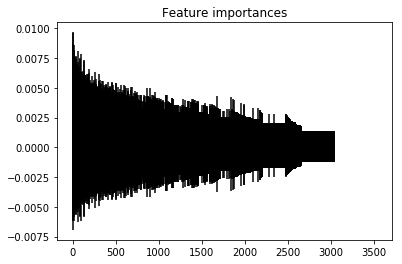

In [44]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train, Y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
for i in enumerate(indices):
    